In [ ]:
# %tensorflow_version 2.x
# import tensorflow as tf
# print("Tensorflow version " + tf.__version__)

# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# from tensorflow.keras.datasets import mnist
# (x_train, y_train), (x_test, y_test) = mnist.load_data()
# print(x_train.shape) # (60000, 28, 28)
# print(y_train.shape) # (60000,)
# print(x_train.size/1024/1024,"mb")

In [1]:
%%capture
!pip install tensorflow keras autokeras pandas numpy matplotlib --upgrade

In [3]:
import tensorflow as tf
tf.debugging.set_log_device_placement(True)
print("Tensorflow version " + tf.__version__)
import gc
import os
import pprint
import autokeras as ak
from glob import glob
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from distutils.dir_util import copy_tree
from tensorflow.python.client import device_lib
import multiprocessing as mp

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 100
pd.options.display.max_colwidth = 100
pd.options.display.precision = 8
pd.options.display.float_format = '{:,.3f}'.format

Tensorflow version 2.2.0


Using TensorFlow backend.


In [4]:
gpu_info = str(device_lib.list_local_devices()[-1])
print("CPU Core count", mp.cpu_count())
if "CPU" in gpu_info:
    print("No GPU")
else:
    print("GPU info:\n", gpu_info)

CPU Core count 4
No GPU


In [21]:
project_dir = os.path.dirname(os.getcwd())+os.sep
data_dir = os.path.join(project_dir, "data")+os.sep
interim_dir = os.path.join(data_dir, "interim")+os.sep
train_dir = os.path.join(interim_dir, "train")+os.sep
test_dir = os.path.join(interim_dir, "test")+os.sep
img_size = (560, 440)  # keras needs this as height, width but TF has it as width, height

In [22]:
def find_rdf(path):
    roots, directories, n_examples = [], [], []
    for root, directory, file in os.walk(path):
        roots += [root]
        directories += directory
        n_examples += file
        root = roots[0]
    return root, directories, n_examples

train_walk = find_rdf(train_dir)
test_walk = find_rdf(test_dir)
n_examples = len(train_walk[2])

In [23]:
ml_dtype_pths = dict(zip(["train", "test"], [train_walk[0], test_walk[0]])) 
ml_dtype_pths["train"]

'D:\\Users\\gjnet\\code_projects\\kaggle_ccs\\data\\interim\\train\\'

In [24]:
files_dct = dict()
for ml_dtype in ml_dtype_pths.keys():
    files_dct[ml_dtype] = []
    if ml_dtype != "test":
        for outcome_type in train_walk[1]:
            files_dct[ml_dtype] += glob(ml_dtype_pths[ml_dtype]+outcome_type+os.sep+"*.jpg")
    else:
        files_dct[ml_dtype] += glob(ml_dtype_pths[ml_dtype]+"unlabelled"+os.sep+"*.jpg")

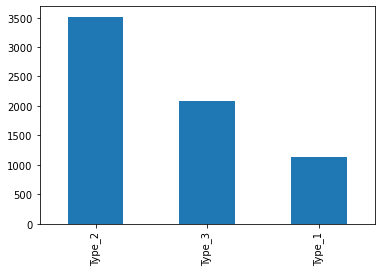

In [25]:
filenames_df = pd.DataFrame(files_dct["train"], columns=["filepath"])
filenames_df["class"] = filenames_df["filepath"].str.extract("(t\d)").squeeze().str.replace("t","Type_")
filenames_df = filenames_df.astype("category")
cls_val_cnts = filenames_df["class"].value_counts()
cls_val_cnts.plot(kind="bar")

In [26]:
def printDivisors(n, min=32, max=512): 
    i = 1
    n_w = n
    divs = []
    while (i <= n_w): 
        if (n_w % i==0) & (i >= min) & (i <= max):  # batch size
            drop_n = n-n_w
            print("Int divisor for", n_w, "is", str(i)+". Drop", drop_n,"image groups.")
            return i
        if (n_w == i):
            n_w -= 1
            i = 0
        i = i + 1
batch_size = printDivisors(n_examples)
over_sample_weight = 1*printDivisors(n_examples, 4, 10)

Int divisor for 6728 is 58. Drop 1 image groups.
Int divisor for 6728 is 4. Drop 1 image groups.


In [27]:
# # Test augmentations
# from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
# img = load_img(train_dir+"Type_2"+os.sep+"trn_0_add_t2.jpg")
# x = img_to_array(img)  # this is a Numpy array with shape (560, 440, 3)
# x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 560, 440, 3)

# i = 0
# for batch in datagen.flow(x, batch_size=1, save_to_dir=augmented_dir, save_format='jpg'):
#     i += 1
#     if i > 20:
#         break  # otherwise the generator would loop indefinitely

In [28]:
def preprocess(img):
    img = array_to_img(img, scale=False)
    # img = img.resize((img_size[0], img_size[1]))
    img = img_to_array(img)
    return img  # / 255.0


image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    rotation_range=90,
    shear_range=0.2,
    fill_mode="reflect",
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.08,
    preprocessing_function=preprocess,
    # dtype=np.float16,
    # rescale=1./255
    )

train_generator = image_generator.flow_from_directory(
    directory=train_dir,
    target_size=img_size,
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True,
    seed=123,
    # interpolation="mitchellcubic",
    subset='training',
    )

val_generator = image_generator.flow_from_directory(
    directory=train_dir,
    target_size=img_size,
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True,
    seed=123,
    # interpolation="mitchellcubic",
    subset='validation',
    )

def callable_iterator(generator):
    for img_batch, targets_batch in generator:
        yield img_batch, targets_batch

train_dataset = tf.data.Dataset.from_generator(
    lambda: callable_iterator(train_generator),
    output_types=(tf.float32, tf.float32))

val_dataset = tf.data.Dataset.from_generator(
    lambda: callable_iterator(val_generator),
    output_types=(tf.float32, tf.float32))

Found 5384 images belonging to 3 classes.
Found 1345 images belonging to 3 classes.
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0


Executing op TakeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Image shape:  (58, 560, 440, 1)
Label:  [0. 0. 1.]


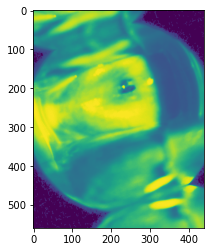

In [30]:
import matplotlib.pyplot as plt
for image, label in train_dataset.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy()[0])
    plt.imshow(image.numpy()[0].squeeze(axis=2))
    plt.show()

In [ ]:
%%time
def create_model(max_trials=100):
    clf = ak.ImageClassifier(
      loss="categorical_crossentropy",
      max_trials=max_trials,
      overwrite=True,
      seed=123,
      )

    #Feed the tensorflow Dataset to the classifier.
    clf.fit(train_dataset)
    #Evaluate the best model.
    print(clf.evaluate(val_dataset))

    return clf

# with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
clf = create_model()

Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReduceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
